# Run a REopt API evaluation

## Initialization

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
from src.post_and_poll import get_api_results
API_KEY = 'uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC'  # REPLACE WITH YOUR API KEY

In [2]:
# following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [3]:
"""
Here are some convenience definitions for using the Multi-scenario capabilities
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Load a previously saved API response .json file instead of running REopt

In [44]:
response_json = '4_kgal_limit_fixed_pv_2.85MW'
with open(os.path.join(outputs_path, response_json + '.json'), 'rb') as handle:
    api_response = json.load(handle)

## Scenario Inputs (POST), if wanting to do a new API call

In [49]:
post_1 = {"Scenario": {
    "optimality_tolerance_techs": 0.001,
    "Site": {
        "longitude": -106.5527591,
        "latitude": 35.0488506,
        "land_acres": 1.0e6,
        "roof_squarefeet": 1.0e9,
        # "renewable_electricity_min_pct": 0.0,
        # "renewable_electricity_max_pct": 0.0,
        # "co2_emissions_reduction_min_pct": None,
        # "co2_emissions_reduction_max_pct": None, # even if None or 1.0, this will trigger emissions constraints
        "off_grid_flag": False,
        "include_climate_in_objective": False,
        "LoadProfile": {
            "loads_kw": [],  # Populated below
            "critical_load_pct": 0.999,  # Modeling all load = critical load
            "critical_loads_kw": [],  # Not needed, using loads_kw and critical_load_pct = 1.0
            "outage_start_time_step": 4565, #1540,  # just to make sure generator is sized >0
            "outage_end_time_step": 4565 + 2*168,  # defined below
            "outage_is_major_event": True,  # Not used in the optimization, only for value of lost load
            "year": 2017,  # Consistent with using CRB's which we pre-process and combine into an aggregated load below
        },
        "ElectricTariff": {
            "blended_annual_rates_us_dollars_per_kwh": 0.04,
            "blended_annual_demand_charges_us_dollars_per_kw": 0.0,
            "wholesale_rate_us_dollars_per_kwh": 0.04
        },
        "Generator": {
            "min_kw": 3000.0,        
            "max_kw": 3000.0,
            "diesel_fuel_cost_us_dollars_per_gallon": 3.0,        
            "installed_cost_us_dollars_per_kw": 800.0,  # From Jimmy
            "om_cost_us_dollars_per_kw": 20.0,
            "om_cost_us_dollars_per_kwh": 0.0,        
            "fuel_slope_gal_per_kwh": 0.08217,  # 30% HHV efficiency 
            "fuel_intercept_gal_per_hr": 0.0,
            "fuel_avail_gal": 12000.0,
            "min_turn_down_pct": 0.0,
            "existing_kw": 0.0,
            "generator_only_runs_during_grid_outage": True,
            "generator_sells_energy_back_to_grid": False,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
        },      
        "PV": {
            # "min_kw": 0.0,
            # "max_kw": 0.0,
            "installed_cost_us_dollars_per_kw": 1256.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021
            "om_cost_us_dollars_per_kw": 22.0,  # From Dan's analysis, NOT REopt default, ATB 2020
            "array_type": 2,
            "federal_itc_pct": 0.0,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
            "macrs_itc_reduction": 0.0
        },
        "Storage": {
            "max_kw": 0.0,
            "max_kwh": 0.0,
            "soc_init_pct": 0.5,
            "soc_min_pct": 0.2,
            "installed_cost_us_dollars_per_kw": 220.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021 UTILITY SCALE SEEMS WAY LOW
            "installed_cost_us_dollars_per_kwh": 424.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021 UTILITY SCALE
            "replace_cost_us_dollars_per_kw": 220.0/2.0,  # Assume half cost for inverter replacement
            "replace_cost_us_dollars_per_kwh": 424.0/2.0,  # Assume half cost for battery pack replacement
            "inverter_replacement_year": 12,
            "battery_replacement_year": 12,
            "can_grid_charge": False,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
            "macrs_itc_reduction": 0.0,
            "total_itc_pct": 0,
        },
        "Financial": {
            "om_cost_escalation_pct": 0.0,
            "escalation_pct": 0.0,
            "generator_fuel_escalation_pct": 0.0,
            "offtaker_tax_pct": 0.0,
            "offtaker_discount_pct": 0.03,
            "analysis_years": 25,
            "co2_cost_us_dollars_per_tonne": 0.0  # Only used if Site.include_climate_in_objective = True
        }
}}}
post_1["Scenario"]["Site"]["LoadProfile"]["loads_kw"] = list(building_load_profiles_df["All"].values)

### Load in EACI (cricital) load data for Kirtland microgrid

In [5]:
# New/updated all buildings load profile
building_load_profiles_df = pd.read_csv('./load_profiles/building_load_profiles_03082022_JEQ.csv', index_col=0)

In [6]:
import matplotlib.pyplot as plt
import random

Text(0.5, 1.0, 'Microgrid Load')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
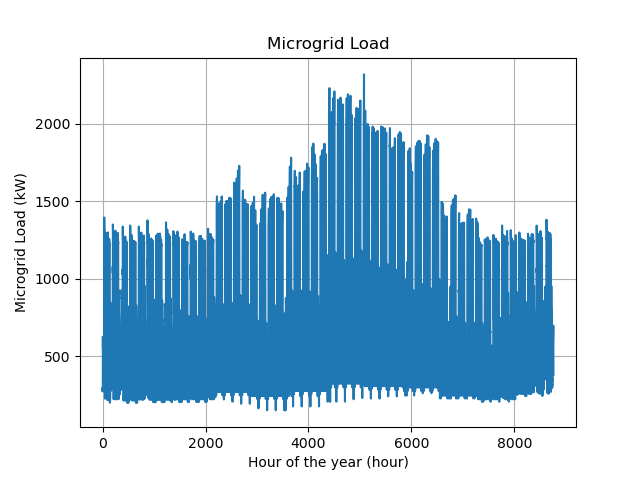

In [22]:
%matplotlib widget
plt.plot(building_load_profiles_df["All"].values)
plt.grid()
# plt.legend()
plt.ylabel("Microgrid Load (kW)")
plt.xlabel("Hour of the year (hour)")
plt.title("Microgrid Load")

In [8]:
np.max(building_load_profiles_df["All"].values)

2319.1

In [23]:
# Determine which load will be used for the electric load profile and critical load
post_1["Scenario"]["Site"]["LoadProfile"]["loads_kw"] = list(building_load_profiles_df["All"].values)
# From post_1 definition above, critical_load_pct = 1 which is what we want

### Load in a custom electric rate generated from https://reopt.nrel.gov/tool/custom_tariffs

In [6]:
load_electric_rate = "PGE_E20"
with open(os.path.join(rates_path, load_electric_rate + ".json"), 'r') as fp:
    rate_1 = json.load(fp)
post_1["Scenario"]["Site"]["ElectricTariff"]["urdb_response"] = rate_1

## Save the POST to a .json file for sharing or future loading in

In [7]:
# Convert python dictionary post into json and save to a .json file
post_save = post_1
post_name = "post_1"
with open(os.path.join(inputs_path, post_name + ".json"), 'w') as fp:
    json.dump(post_save, fp)

## Or load in a saved .json file for the inputs/POST

In [4]:
# Load a json into a python dictionary
load_post = "midrise"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_1 = json.load(fp)

## POST and poll (periodic GET request) the API to GET a new result, if not loading in a previous response. This may take a while!

### Note, the `api_url` in the `get_api_results` function below calls the **production server** hosted API (master/main branch/version, publicly accessible)

#### For calling a locally-hosted (localhost) API, see:
- https://github.com/NREL/REopt_Lite_API/wiki/localhost-URLs-for-calling-locally-hosted-API

#### For calling an API hosted on an NREL-internal server (only NREL users can access this), see:
- https://github.nrel.gov/REopt/API_scripts/wiki/API-URLs-for-NREL-internal-servers

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

A log file is also created in the current working directory.

In [50]:
root_url = "https://developer.nrel.gov/api/reopt/v1"
outputs_path = './outputs/Latest runs'
outputs_file_name = "12_kgal_limit_size_pv_no_battery"
api_response = get_api_results(post=post_1,
                                   API_KEY=API_KEY,
                                   api_url=root_url,
                                   results_file=os.path.join(outputs_path, outputs_file_name + ".json"), 
                                   run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/v1/job/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC.
main         INFO     Polling https://developer.nrel.gov/api/reopt/v1/job/9d0c4b18-04f0-4209-a718-782ee8b0d0b8/results/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC for results with interval of 5s...
main         INFO     Saved results to ./outputs/Latest runs/12_kgal_limit_size_pv_no_battery.json


### If you get disconnected from the polling function but you think it ran, copy the run_uuid from the log above to manually GET the results:

In [12]:
run_uuid = api_response["outputs"]["Scenario"]["run_uuid"]
print("run_uuid = ", api_response["outputs"]["Scenario"]["run_uuid"])
results_url = root_url + '/job/' + run_uuid + '/results/?api_key=' + API_KEY
resp = requests.get(url=results_url, verify=False)
api_response = json.loads(resp.text)

run_uuid =  a8b6bca7-8fc7-4f90-9c38-43143c685608


## Get summary of results

In [51]:
print("NPV ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["npv_us_dollars"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["net_capital_costs"])
tech_list = ["PV", "Wind", "Storage", "CHP", "Generator", "HotTES", "ColdTES", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post_1["Scenario"]["Site"].keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
        for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])
    elif tech in ["PV", "Storage"]:
        for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])                

NPV ($) =  -4925149.0
Capital Cost, Net ($) =  5501176.66
PV size_kw  =  2469.0897
Storage size_kw  =  0.0
Storage size_kwh  =  0.0
Generator size_kw  =  3000.0


## Save API response into a JSON file for later use

In [17]:
response_save = api_response
file_name_to_save = "response_1"
with open(os.path.join(outputs_path, file_name_to_save + ".json"), 'w') as fp:
    json.dump(response_save, fp)